## tiff2nc-WISE
- Created by Will Wieder
- March 2022

### Converts geoTiff file from WISE to .nc files for use in mksurf

Combines gridded map units at 30sec resolution (1km) with Lookup table with soil properties.

Lookup table has 3 coordinates: 
- Map units that correspond to the gridded maps, which have information from 
- Multiple soil profiles (ranked in order of abundance), each with 
- Depth resolved properties, 7 vertical layers (0-2m depth)

#### Data available at [isric website](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc/formatters/xsl-view?root=div&view=advanced&approved=true)


retrieved with the following command:

`wget https://files.isric.org/public/wise/wise_30sec_v1.zip `

Finally, information about units & conversions for each variable are here: 
- Batjes NH 2016. Harmonised soil property values for broad-scale modelling (WISE30sec) with estimates of global soil carbon stocks. [Geoderma 2016(269), 61-68](http://dx.doi.org/10.1016/j.geoderma.2016.01.034) and
- Technical documentation [provided here](https://library.wur.nl/WebQuery/wurpubs/fulltext/400244)

The last plotting cell overloads memory, even using dask workers, as below.

Instead, getting 100GB of memory seems through JupyterHub seems to work.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
#from affine import Affine
import matplotlib.pyplot as plt
from glob import glob
import dask
from distributed import wait
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Get some workers

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
## Note, this doesn't seem to work when logging onto JupyterHub
cluster, client = get_ClusterClient(nmem='10GB')
cluster.scale(20)
cluster

/glade/u/home/wwieder/miniconda3/envs/tiff2nc/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:43613,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## point to raw datasets

In [4]:
path ='/glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/'
infile = path + 'wise_30sec_v1.tif'
Lookup = path + 'HW30s_FULL.txt'

In [5]:
lookup = pd.read_csv(Lookup, sep=',')
print('Lookup unique profiles = ' + str(len(lookup.NEWSUID.unique()) ) )
lookup.where(lookup.NEWSUID == 'WD10001666').dropna().head()

Lookup unique profiles = 16413


,NEWSUID,SCID,PROP,CLAF,PRID,Drain,DrainNum,Layer,TopDep,BotDep,...,ESP,ESP_std,PHAQ,PHAQ_std,TCEQ,TCEQ_std,GYPS,GYPS_std,ELCO,ELCO_std
0,WD10001666,1.0,70.0,RGe,RGe/A,S,6.0,D2,20.0,40.0,...,4.0,3.0,6.4,0.6,0.0,0.0,29.0,33.0,1.0,1.0
193,WD10001666,1.0,70.0,RGe,RGe/A,S,6.0,D3,40.0,60.0,...,4.0,3.0,6.5,0.6,0.0,0.0,6.0,7.0,1.0,1.3
155698,WD10001666,2.0,30.0,LPq,LPq/A,E,7.0,D1,0.0,20.0,...,3.0,2.0,6.7,1.3,0.0,0.0,3.0,6.0,1.0,1.0
156294,WD10001666,2.0,30.0,LPq,LPq/A,-7,-9.0,D2,20.0,40.0,...,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0
156890,WD10001666,2.0,30.0,LPq,LPq/A,-7,-9.0,D3,40.0,60.0,...,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0


### Each mapping unit may have information about multiple profiles 
- this example has 2

In [6]:
# Drop characters off the front of map units and conver to intiger
lookup['MapUnit'] = (lookup.NEWSUID.str[4:]).astype(int)
print(lookup['MapUnit'].unique())
print(len(lookup['MapUnit'].unique()))

[ 1666  6309  1700 ...  7230  6997 32091]
16413


In [7]:
# convert to multi index and then create xarray dataset
lookup = lookup.set_index(['MapUnit','SCID','BotDep']).sort_index()
dsLook = lookup.to_xarray()
#dsLook

In [8]:
# Convert to Xarray dataset for mapping to CLM structures
# add meta data from Appendix 9 of technical documentation 
dsLook = lookup.to_xarray()
dsLook.MapUnit.attrs['long_name'] = 'WISE mapping unit'
dsLook.NEWSUID.attrs['long_name'] = 'Globally unique map unit code, see Appendix 4'
dsLook.SCID.attrs['long_name'] = 'Number of soil unit within the given map unit (ranges from 1 to 10)'
dsLook.PRID.attrs['long_name'] = 'profile ID (as documented in table HW30S_MapUnit, see Appendix 6)'
dsLook.Drain.attrs['long_name'] = 'FAO soil drainage class'
dsLook.TopDep.attrs['long_name']  = 'depth of top of layer'
dsLook.TopDep.attrs['units'] = 'cm'
dsLook.BotDep.attrs['long_name'] = 'depth of bottom of layer'
dsLook.BotDep.attrs['units'] = 'cm'
dsLook.CFRAG.attrs['long_name'] = 'coarse fragments'
dsLook.CFRAG.attrs['units'] = 'vol% > 2 mm'

dsLook.SDTO.attrs['long_name'] = 'sand'
dsLook.SDTO.attrs['units']  = 'mass %'
dsLook.STPC.attrs['long_name'] = 'silt'
dsLook.STPC.attrs['units']  = 'mass %'
dsLook.CLPC.attrs['long_name'] = 'clay'
dsLook.CLPC.attrs['units']  = 'mass %'
dsLook.BULK.attrs['long_name'] = 'bulk density'
dsLook.BULK.attrs['units']  = '(kg dm^-3, g cm^-3'
dsLook.TAWC.attrs['long_name'] = 'available water capacity (-33 to -1500 kPa conform to USDA standards)'
dsLook.TAWC.attrs['units'] = 'cm m^-1'

dsLook.CECS.attrs['long_name'] = 'cation exchange capacity for fine earth fraction'
dsLook.CECS.attrs['units'] = 'cmol_c kg^-1'
dsLook.CECc.attrs['long_name'] = 'CECclay, corrected for contribution of organic matter'
dsLook.CECc.attrs['units'] = 'cmol_c kg^-1'
dsLook.TEB.attrs['long_name'] = 'total exchangeable bases'
dsLook.TEB.attrs['units'] = 'cmol_c kg^-1'
dsLook.BSAT.attrs['long_name'] = 'Base saturation as percentage of CECsoil'
dsLook.BSAT.attrs['units'] = 'None'
dsLook.ECEC.attrs['long_name'] = 'effective CEC'
dsLook.ECEC.attrs['units'] = 'cmol_c kg^-1'

dsLook.PHAQ.attrs['long_name'] = 'pH measured in water'
dsLook.PHAQ.attrs['units'] = 'None'
dsLook.TCEQ.attrs['long_name'] = 'total carbonate equivalent'
dsLook.TCEQ.attrs['units'] = 'gC kg^-1'
dsLook.ORGC.attrs['long_name'] = 'organic carbon content'
dsLook.ORGC.attrs['units'] = 'gC kg^-1'
dsLook.TOTN.attrs['long_name'] = 'total nitrogen'
dsLook.TOTN.attrs['units'] = 'gN kg^-1'
dsLook.CNrt.attrs['long_name'] = 'C/N ratio'
dsLook.CNrt.attrs['units'] = 'None'

dsLook.attrs['source data'] = 'https://files.isric.org/public/wise/wise_30sec_v1.zip'
dsLook.attrs['doucmentation'] = 'https://library.wur.nl/WebQuery/wurpubs/fulltext/400244'
dsLook.attrs['publication'] = 'https://doi.org/10.1016/j.geoderma.2016.01.034'
dsLook.attrs['accessed'] = '11 March, 2022'
dsLook.attrs['notes'] = 'generated by Will Wieder'
dsLook.attrs['source code'] = 'tiff2nc-WISE.ipynb'

[0.0175 0.0451 0.0906 0.1656 0.2892 0.493  0.829  1.3829 2.2962 3.4332]
[0.2 0.4 0.6 0.8 1.  1.5 2. ]


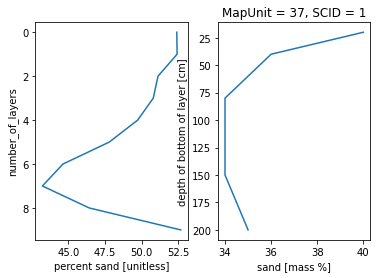

In [9]:
## Open file with target dimensions for CLM
CLMin = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/rawdata/mksrf_soitex.10level.c010119.nc'
dsCLM = xr.open_dataset(CLMin)
print(dsCLM.ZSOI.values)
print((dsLook.BotDep/100).values[0:7])
plt.subplot(1,2,1)
dsCLM.PCT_SAND.sel(max_value_mapunit=37).plot(y='number_of_layers') 
plt.gca().invert_yaxis();
plt.subplot(1,2,2)
dsLook.SDTO.isel(MapUnit = 2, SCID=0).plot(y='BotDep')
plt.gca().invert_yaxis();

- CLM layers 0-3 (<0.16) are 0-20 cm for WISE [0]
- CLM layer 4 (0.29) is 20-40 cm for WISE
- CLM layer 5 (0.49) is 40-60 cm for WISE
* no CLM layer for WISE data 60-80
- CLM layer 6 (0.83) is 80-100 cm for WISE
- CLM layer 7 (1.38) is 100-150 cm for WISE
- CLM layers 8-9 are 150-200 cm for WISE
#### make a new output datset with 10 layers, cooresponding to CLM layers

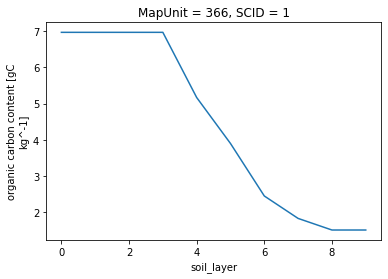

In [15]:
MapUnit = dsLook.MapUnit
SCID = dsLook.SCID
soil_layer = dsCLM.number_of_layers.rename({'number_of_layers':'soil_layer'})
#dsOUT = xr.Dataset(data_vars=None,
#                   coords=({'MapUnit' : MapUnit,    
#                            'SCID': SCID,
#                            'soil_layer': soil_layer}) )
temp0 = dsLook.rename({'BotDep': 'soil_layer'})
var = ['PRID','Drain','CFRAG','SDTO','STPC','CLPC','BULK','TAWC',
       'CECS','CECc','TEB','BSAT','ECEC','PHAQ',
       'TCEQ','ORGC','TOTN','CNrt']

for i in range(len(var)):
    # CLM layers 0:3 in CLM are in WISE layer 0
    temp = temp0[var[i]][:,:,0]
    tempMerge = xr.concat([temp,temp,temp,temp],dim='soil_layer')

    # CLM layer 4:5  in CLM are in WISE layer 1:2
    temp = temp0[var[i]][:,:,1:3]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # CLM layer 6:8  in CLM are in WISE layer 4:6
    temp = temp0[var[i]][:,:,4:]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # CLM layer 9  in CLM are in WISE layer 6
    temp = temp0[var[i]][:,:,6]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')
    if i == 0:
        dsOUT = tempMerge.to_dataset(name=var[i])
    else:
        dsOUT[var[i]] = tempMerge

# switch to CLM soil layer convention
dsOUT['soil_layer'] = soil_layer
dsOUT['ORGC'].isel(MapUnit=100,SCID=0).plot() ; 
dsOUT.attrs = dsLook.attrs
dsOUT['ZSOI'] = dsCLM.ZSOI.rename({'number_of_layers':'soil_layer'})
dsOUT['DZSOI']= dsCLM.DZSOI.rename({'number_of_layers':'soil_layer'})
dsOUT = dsOUT.transpose("MapUnit", "SCID", "soil_layer")
#dsOUT

## open .tif as rioxarray to bring in meta and projection data

In [11]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    rds = rioxarray.open_rasterio(infile)

rds = rds.rename({'x': 'lon','y': 'lat'})
rds = rds.isel(band=0).to_dataset(name='MU')
rds = rds.reset_coords(names=['spatial_ref','band'], drop=True)
rds = rds.astype(int)
rds = rds.where(rds>0)
rds = rds.load()
_ = wait(rds)

In [12]:
## Check to see that dimensions are the same for lookup table and grid
df  = rds.to_dataframe()
df.MU.attrs['_FillValue'] = 0
print('gridded unique profiles = ' + str(len(df.MU.unique()) ) )
print('Lookup unique profiles = ' + str(len(dsOUT.MapUnit) ) )
print(' -- grid has extra value for missing data, ocean -- ')

gridded unique profiles = 16414
Lookup unique profiles = 16413
 -- grid has extra value for missing data, ocean -- 


In [13]:
df.MU = df.MU.where(df.MU>0)
print('min mapunit lookup = '+str(dsOUT['MapUnit'].values.min())+', grid ='+str(df.MU.min()) )
print('max mapunit lookup = '+str(dsOUT['MapUnit'].values.max())+', grid ='+str(df.MU.max()) )

min mapunit lookup = 2, grid =2.0
max mapunit lookup = 32156, grid =32156.0


In [14]:
## now merge the datasets 
rds.MU.attrs['long_name']= 'WISE30sec MapUnit'
ds = xr.merge([rds,dsOUT])
ds = ds.rename({'SDTO':'PCT_SAND',
                'STPC':'PCT_SILT',
                'CLPC':'PCT_CLAY',
               })
ds.attrs = dsOUT.attrs
ds.load()
_ = wait(ds)

In [17]:
## Write out .nc file
fout = path + 'wise_30sec_v1.nc'
ds.to_netcdf(fout)
print('wrote '+fout)

wrote /glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/wise_30sec_v1.nc


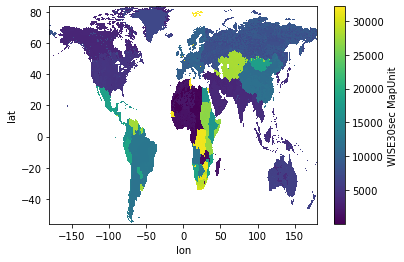

In [18]:
# This takes forver, or overloads memory
ds.MU.plot() ;

-------

In [19]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2022-03-17

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Git hash: cd3e934a9f0db49cef03b3323cab67400d61c542

Git repo: git@github.com:wwieder/ctsm_py.git

Git branch: master

numpy     : 1.21.5
dask      : 2021.10.0
rioxarray : 0.8.0
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
xarray    : 0.20.2
json      : 2.0.9
matplotlib: 3.5.1
pandas    : 1.3.5

